# Homework 2: Line Detection

## Problem 1: Preprocessing

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from util import ops
from util.keypoint_detection import HessianDetector

### Load Image Data

In [2]:
original_image = ops.load_image("./original-images/road.png")

Dimensions of ./original-images/road.png: 407 x 548


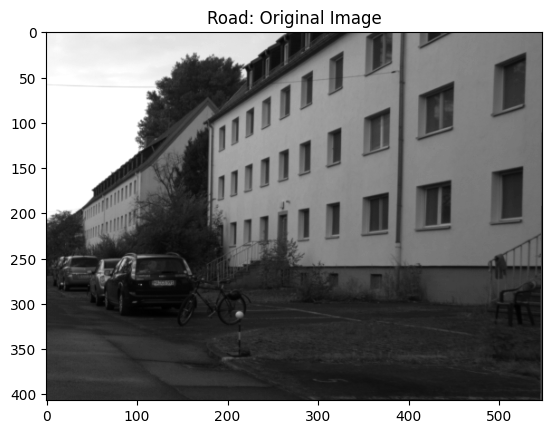

In [3]:
plt.title("Road: Original Image")
plt.imshow(original_image, cmap="gray")
plt.show()

(407, 548)
2 223036 223036


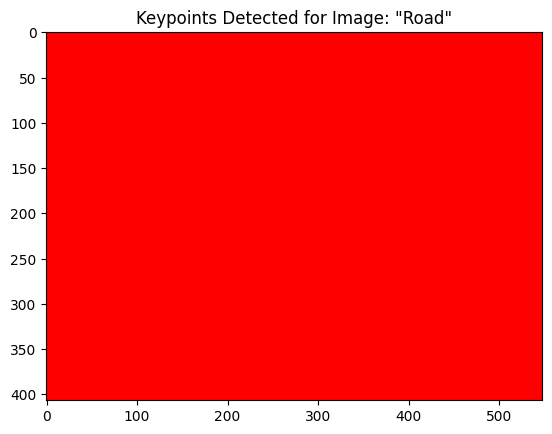

In [4]:
HessianDetector.find_keypoints_and_visualize(
    np.array(original_image), 
    "Road",
    threshold=99  # let's arbitrarily start testing, using the 75th percentile of 
)